# Machine learning voor tumor afbeelding herkenning (opdracht 2)

### Imports

In [1]:
# All import statements used in the code
# File paths
import os

# Loading images
from PIL import Image
import cv2

# Calculations
import numpy as np
import random

# Model evaluation and training
import tensorflow as tf
from tensorflow.math import confusion_matrix
import keras

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

### Data inladen

In [2]:
# make variables for saving the images/labels
train_images = []
test_images = []
train_labels = []
test_labels = []

# Get all the patient directories
current_map = "idc_regular"
patient = [file for file in os.listdir(current_map)]

In [3]:
# Counter is used to split data into test and training (80/20)
counter = 0

# For each patient data images are collected
for person in patient:
    counter += 1
    # File paths to the positive and negative images (each patient)
    pos_path = f"{current_map}/{person}/1"
    neg_path = f"{current_map}/{person}/0"
    
    # Every 5th patient's data is used as test data
    if counter == 5:
        # Get all the positive image names
        pos_files = os.listdir(pos_path)
        length_pos = len(pos_files)
        # Only use a (random) quater of all the positive images
        for ind in random.sample(range(0, length_pos), int(length_pos/4)):
            saved = np.asarray(Image.open(f"{pos_path}/{pos_files[ind]}"))
            # Only the complete images are used
            if saved.shape == (50, 50, 3):
                test_images.append(saved)
                test_labels.append(1)
    
        # Get all the negative image names
        neg_files = os.listdir(neg_path)
        length_neg = len(neg_files)
        # Only use a (random) quater of all the negative images
        for ind in random.sample(range(0, length_neg), int(length_neg/4)):
            saved = np.asarray(Image.open(f"{neg_path}/{neg_files[ind]}"))
            # Only the complete images are used
            if saved.shape == (50, 50, 3):
                test_images.append(saved)
                test_labels.append(0)
        # Reset the counter to split the data correctly
        counter = 0

    # All the other patient's data is used as train data
    else:
        # Get all the positve image names
        pos_files = os.listdir(pos_path)
        length_pos = len(pos_files)
        # Only select a (random) quater of all positive images
        for ind in random.sample(range(0, length_pos), int(length_pos/4)):
            saved = np.asarray(Image.open(f"{pos_path}/{pos_files[ind]}"))
            # Only the complete images are saved
            if saved.shape == (50, 50, 3):
                train_images.append(saved)
                train_labels.append(1)

        # Get all the negative image names
        neg_files = os.listdir(neg_path)
        length_neg = len(neg_files)
        # Only select a (random) quater of all the negative images
        for ind in random.sample(range(0, length_neg), int(length_neg/4)):
            saved = np.asarray(Image.open(f"{neg_path}/{neg_files[ind]}"))
            # Only the complete images are saved
            if saved.shape == (50, 50, 3):
                train_images.append(saved)
                train_labels.append(0)

# Set all the lists to numpy array for eassier model training
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Voor de bovenstaande code is ervoor gekozen om niet alle afbeeldingen in te laden. Er wordt een kwart van de negatieve en kwart van de positieve afbeeldingen van elke patiënt gebruikt. Deze afbeeldingen worden hierbij random gekozen, om te voorkomen dat de x- en y-coördinaten van de afbeeldingen (te) dicht bij elkaar liggen. <br>
De reden om de hoeveelheid data te verkleinen is om zo de runtime flink te verkorten. Daarnaast wordt ook overfitting op de data van een bepaalde patiënt voorkomen, doordat het gebruik van een kwart een grotere hoeveelheid data wegneemt bij deze patiënten.

Daarnaast worden ook de niet complete afbeeldingen ((50, 50, 3)), niet gebruikt voor het trainen van het model. Voor een np.array moeten de grotes (van de afbeeldingen) constant zijn, waardoor het toestaan van incomplete afbeeldingen een error oplevert. Daarbij maakt dit het trainen van het model een stuk gemakkelijker, waardoor hiervoor is gekozen.

In [6]:
train_images.shape

(53836, 50, 50, 3)

In ons geval worden er ruim 53.000 train afbeeldingen en 14.000 test afbeeldingen overgehouden na het inladen van de data. Elke keer dat de data wordt ingeladen kan dit variëren (door het gebruik van random), waardoor de resultaten kunnen afwijken van de door ons gevormde resultaten.

### Model aanmaken

In [28]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(128, activation='relu'), # Could be lower for my computer
    keras.layers.Dense(2, activation="softmax") # Number between the 0 and 1
])

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(), # from_logits=True
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

c:\Users\gielb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Het model kan worden uitgebreid voor mogelijk betere resultaten.

### Model trainen

In [29]:
hist = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 90.1263 - sparse_categorical_accuracy: 0.6963
Epoch 2/5
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 16.4943 - sparse_categorical_accuracy: 0.7234
Epoch 3/5
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5.5421 - sparse_categorical_accuracy: 0.7284
Epoch 4/5
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.9433 - sparse_categorical_accuracy: 0.7539
Epoch 5/5
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.4585 - sparse_categorical_accuracy: 0.7909


Het inladen van de data is een proces dat lang duurt, waarna een deel van de data wordt overgehouden. Een voordeel hiervan is dat het trainen van het model hierdoor een stuk sneller gaat. Het is aangeraden om het aantal epochs of het aantal/soort layers van het model te veranderen. <br>
Dit model is getest op meerdere epochs en layer soorten, alleen gaven de bovenstaande instelling de beste resultaten. Bij **model evaluatie** wordt dit verder besproken.

### Model evaluatie

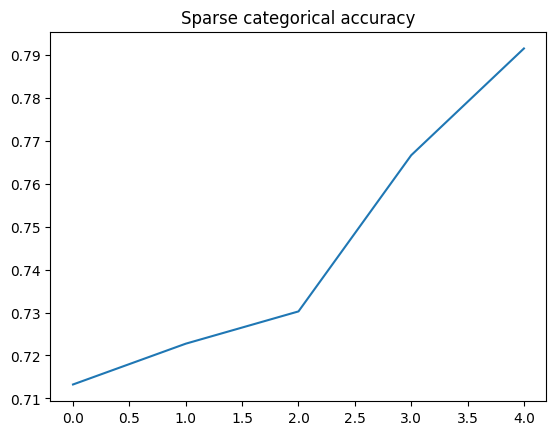

In [32]:
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.title("Sparse categorical accuracy")
plt.show()

463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


<Axes: >

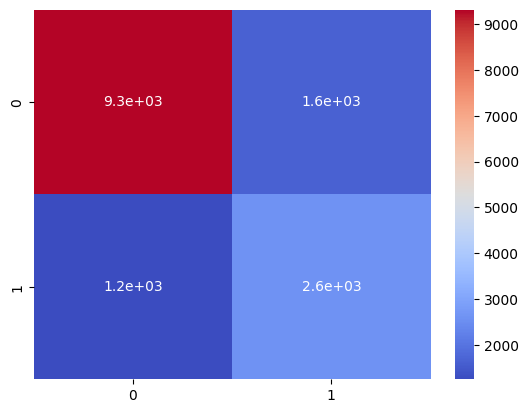

In [31]:
y_pred = model.predict(test_images)
df = np.asarray(confusion_matrix(np.argmax(y_pred, axis=1), test_labels))
sns.heatmap(df, annot=True, cmap='coolwarm')

Bij het trainen van het model zijn er meerdere dingen geprobeerd. Eerst is het goed om te weten waarop een model (door ons) beoordeeeld wordt en waarop juist minder. <br>
Er wordt niet echt gekeken naar de accuracy van het model. De hoofdreden hiervoor is de accuracy een vertekend beeld geeft door de grote hoeveelheid negatieve afbeeldingen tegenover de positieve afbeeldingen. Doordat deze verhouding niet (bijna) gelijk is, kan het model altijd negatief voorspellen, een een accuracy van boven de 0.7 hebben. <br>
Met deze reden wordt er vooral gekeken naar de confusionmatrix, waarin de voorspellingen van het model (x-as) tegenover de werkelijke waarde zichtbaar zijn (y-as). Hiermee kan dus goed naar de voorspellingen van het model gekeken worden, waardoor deze voor de evaluatie gebruikt wordt. In deze matrix zijn natuurlijk true positive en true negative het meest gewenst. Ondanks dat false positive incorrect is, kan met verder onderzoek worden vastgesteld dat de patiënt geen tumor heeft. Dit is daarom meer gewenst dan false negative, waarbij de patiënt wel een tumor heeft maar dit niet wordt opgemerkt door het model.

Bij het gebruik van 8 of meer epochs deed het model alleen negatieve voorspelling. De reden hiervoor is de grotere hoeveelheid negatieve waarden in combinatie met overfitting. Ook bij het gebruik van 7 epochs worden er weinig positieve voorspellingen gedaan, waardoor steeds met 5/6 epochs getest is. Bij deze epochs is de accuracy het hoogst en worden zowel positieve als negatieve voorspellingen gedaan. <br>
Eerst is voor de laaste Dense layer 10 gebruikt. Ondanks dat dit model goed scoorde voor de True negative en True positive, is het uiteindelijk niet het beste model gebleken. Het *beste* model was het model met bij de laatste Dense layer 2 en is getraind op 5 Epochs. Bij de 5 Epochs was de accuracy hoog (zie de *sparse categorical accuracy* plot) en alles boven de 5 epochs gaf alleen maar negatieve voorspellingen. <br>
Tot slot is ook geprobeerd om nog een extra Dense layer van 256 toe te voegen, alleen zorgde ook dit ervoor dat er alleen maar negatieve voorspellingen gedaan werden.

### **Conclusie**

Het model met twee Dense layers (128 en 2, zie *model aanmaken*) getraind met 5 Epochs is het beste instaat om de te voorspellen of een afbeelding positief of negatief is voor tumoren. <br>
Het model zou verbeterd kunnen worden door gebruik te maken van een gelijkere verdeling van positieve en negatieve afbeeldingen. Alleen wordt dit door een te kort aan tijd helaas niet getest.